In [1]:
import numpy as N
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import powerspec as P
%matplotlib inline
plt.style.use('nuala')

## Define paths to data and figure directories

In [2]:
multi_sims_path = '/gpfs/data/llinares/2016/log_density/more_runs_lcdm_corrected_ics/analysis/power_corrected_output_density/'
paired_sims_path = '/gpfs/data/llinares/2016/log_density/eight_runs/second_run_all_models/analysis/power_corrected_output_density/runs/'
figurepath = '/cosma/home/nmccull/figures/mg_plots/logxform/paper_plots/'

### Simulation parameters

In [3]:
nruns = 100
ngrid = 1024
lbox = 256.
xx = N.linspace(0, lbox, ngrid)
kbins = N.logspace(N.log10(0.02), N.log10(13), 14)

### Restricted log density transform

In [4]:
def dens_xform(x, A, B, C):
    return (x+A)*N.exp(-(x - B)**2 / (2*C)**2)

In [5]:
# Parameters of transform using rho*exp((rho-rho0)^2/sigma0^2)
A = 3.01
B = -0.13
C = 0.07

In [6]:
# These are the transforms we want to consider
xform = {'dens': lambda x: x, 'log': lambda x: N.log10(x), 'x1': lambda x: dens_xform(N.log10(x), A, B, C)}
xform_label = {'dens': 'Density', 'log': 'Log density', 'x1': 'Restricted log density'}

In [7]:
# Read in 100 x 3 GR density slices and compute the power spectra of the 3 transforms to the density
pk_GR = {}
for i in N.arange(nruns):
    for j in N.arange(3):
        f=open('%sruns_lcdm/run_%i_%02i/density_2d_%i.dat'%(multi_sims_path, ngrid, i, j+1))
        tmp = N.fromfile(f, dtype=N.float, count = 3*ngrid**2)
        tmp = N.reshape(tmp, [ngrid**2,3])
        dens = N.reshape(tmp[:,2], [ngrid, ngrid])
        dens = dens/N.mean(dens)
        if ((i==0) & (j==0)):
            k, pk = P.pkn(dens, kbins, boxsize = lbox)
            for fx in xform.keys():
                pk_GR[fx] = N.zeros([pk.size, 3*nruns], dtype=N.float)
        for fx in xform.keys():
            k, pk_GR[fx][:, 3*i+j] = P.pkn(xform[fx](dens), kbins, boxsize=lbox)

powerspec.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  dk2 = (dk*N.conjugate(dk)).astype(N.float)


In [8]:
# Read in 50 x 3 Symmetron A density slices and compute power spectra of the 3 transforms to the density
pk_symm = {}
nruns_symm = 50
for i in N.arange(nruns_symm):
    for j in N.arange(3):
        f=open('%sruns_symm/run_%i_%02i/density_2d_%i.dat'%(multi_sims_path, ngrid, i+1, j+1))
        tmp = N.fromfile(f, dtype=N.float, count = 3*ngrid**2)
        tmp = N.reshape(tmp, [ngrid**2,3])
        dens = N.reshape(tmp[:,2], [ngrid, ngrid])
        dens = dens/N.mean(dens)
        if ((i==0) & (j==0)):
            k, pk = P.pkn(dens, kbins, boxsize = lbox)
            for fx in xform.keys():
                pk_symm[fx] = N.zeros([pk.size, 3*nruns_symm], dtype=N.float)
        for fx in xform.keys():
            k, pk_symm[fx][:, 3*i+j] = P.pkn(xform[fx](dens), kbins, boxsize=lbox)


In [9]:
# Compute covariance (correlation) matrices of power spectra

corr_GR = {}
cov_GR = {}
corr_symm = {}
cov_symm = {}
pk_mean = {}

for fx in xform.keys():
    corr_GR[fx] = N.corrcoef(pk_GR[fx])
    cov_GR[fx] = N.cov(pk_GR[fx])
    corr_symm[fx] = N.corrcoef(pk_symm[fx])
    cov_symm[fx] = N.cov(pk_symm[fx])
    pk_mean[fx] = N.mean(pk_GR[fx], 1)


In [10]:
ratio_median = {}
ratio_std = {}

for fx in xform.keys():
    ratios = pk_symm[fx] / pk_GR[fx][:, 0:150]
    ratio_median[fx] = N.median(ratios, 1)
    ratio_std[fx] = N.std(ratios, 1)

### Look at the median and 1-sigma spread in the ratio between the Symmetron and GR power spectra for the 3 transforms 

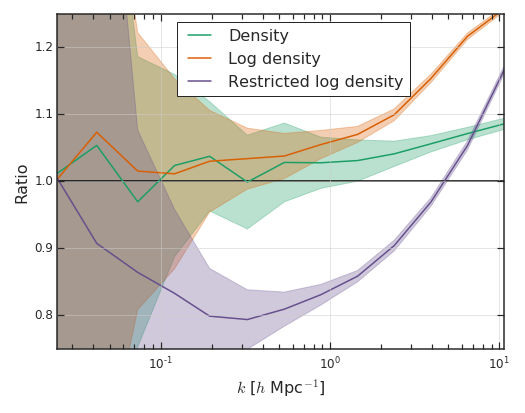

In [11]:
plt.plot([k.min(), k.max()], [1, 1], 'k')
l1={}
for fx in ['dens', 'log', 'x1']:
    l1[fx],=plt.semilogx(k, ratio_median[fx], label=xform_label[fx])
    plt.fill_between(k, ratio_median[fx]-ratio_std[fx]/2.0, ratio_median[fx]+ratio_std[fx]/2.0, color=l1[fx].get_color(), \
                     alpha=0.3)
plt.ylim([0.75, 1.25])
plt.xlabel('$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel('Ratio')
plt.xlim([k.min(), k.max()])
plt.legend(loc=2, bbox_to_anchor=(0.25, 1))
plt.savefig(figurepath+'pk_ratios_symm50_gr50.pdf')

## Read in paired MG-GR simulations and compute spectra of transformed fields

In [12]:
models = ['GR', 'symm_a', 'fofr6']

In [13]:
pk_paired = {}
dens = {}
for mm in models:
    pk_paired[mm] = {}
    for j in N.arange(3):
        f=open('%srun_%s_%i_01/density_2d_%i.dat'%(paired_sims_path, 'lcdm' if mm=='GR' else mm, ngrid, j+1), 'rb')
        tmp = N.fromfile(f, dtype=N.float, count = 3*ngrid**2)
        tmp = N.reshape(tmp, [ngrid**2, 3])
        dens[mm] = N.reshape(tmp[:,2], [ngrid, ngrid])
        dens[mm] = dens[mm] / N.mean(dens[mm])
        
        for fx in xform.keys():
            if (j==0):
                k, pk_paired[mm][fx] = P.pkn(xform[fx](dens[mm]), kbins, boxsize=lbox)
            else:
                k, tmp = P.pkn(xform[fx](dens[mm]), kbins, boxsize=lbox)
                pk_paired[mm][fx] = pk_paired[mm][fx] + tmp

    for fx in xform.keys():
        pk_paired[mm][fx] = pk_paired[mm][fx]/3
    

In [14]:
def ratio_error(pk1, pk2, covmat):
    pk_var = N.diag(covmat)
    return pk1/pk2, pk1/pk2*N.sqrt(pk_var / pk1**2+pk_var/pk2**2)
    

In [19]:
def plot_everything(fig, gs, xx, dens, k, corrmat, label, pk_symma, pk_f6, pk_GR, cov_GR, i, cmap1 = 'inferno', cmap2 = 'PRGn', ncols=3):    
    ax = plt.subplot(gs[0, i], aspect=1)
    
    lower = N.percentile(dens.flatten(), 1)
    upper = N.percentile(dens.flatten(), 99)
    
    mappable = plt.pcolormesh(xx, xx, dens, cmap=cmap1, vmin = lower, vmax = upper)
    plt.title(label)
    plt.xlim([100, 250])
    plt.xticks([120, 160, 200, 240], ['20', '60', '100', '140'])
    plt.ylim([0, 150])
    plt.yticks([20, 60, 100, 140])
    if (i==0):
        plt.ylabel('$y$ [Mpc $h^{-1}$]')
    if (i!=0):
        ax.set_yticklabels('')
    
    
    if (i==ncols-1):
        bbox = ax.get_position()
        cax = fig.add_axes([bbox.xmax*1.01, bbox.ymin+0.013, bbox.width*0.08, bbox.height*0.91])
        cb = fig.colorbar(mappable,cax=cax, ticks = [lower, upper])
        cb.ax.set_yticklabels(['1%', '99%'])
        
    
    ax = plt.subplot(gs[1, i], aspect=1)
    mappable = plt.pcolormesh(kbins, kbins, corrmat, vmin = -1, vmax = 1.0, cmap = cmap2)
    plt.xlim([kbins.min(), kbins.max()])
    plt.ylim([kbins.min(), kbins.max()])
    plt.xscale('log')
    plt.yscale('log')
    ax.set_xticklabels('')
    plt.text(1.5*k.min(), k.max()/6, '%s\n$P(k)$ correlation\nmatrix'%label, fontsize=18)
    #plt.xlabel('$k$ [$h$ Mpc$^{-1}$]')
    if (i!=0):
        ax.set_yticklabels('')
    if (i==0):
        plt.ylabel('$k$ [$h$ Mpc$^{-1}$]')
        
    
    if (i==ncols-1):
        bbox = ax.get_position()
        cax = fig.add_axes([bbox.xmax*1.01, bbox.ymin+0.013, bbox.width*0.08, bbox.height*0.91])
        cb = fig.colorbar(mappable,cax=cax)
    
    ax = plt.subplot(gs[2, i], aspect=1)
    plt.plot([kbins.min(), kbins.max()], [1,1], 'k', lw=1.0)
    ratio1, ratio_err1 = ratio_error(pk_symma, pk_GR, cov_GR)
    ratio2, ratio_err2 = ratio_error(pk_symma, pk_f6, cov_GR)
    l1,=plt.semilogx(k, ratio1)
    plt.fill_between(k, ratio1-ratio_err1/2, ratio1+ratio_err1/2, alpha=0.2, color=l1.get_color())
    l2,=plt.semilogx(k, ratio2)
    plt.fill_between(k, ratio2-ratio_err2/2, ratio2+ratio_err2/2, alpha=0.2, color=l2.get_color())
    
    if (i!=0):
        ax.set_yticklabels('')
    if (i==0):
        plt.legend([l1, l2], [r'$P_{\rm symm}(k)/P_{\rm GR}(k)$', r'$P_{\rm symm}(k)/P_{f(R)}(k)$'], loc=4)
        plt.ylabel('Ratio of $P(k)$')
    plt.xlabel('$k$ [$h$ Mpc$^{-1}$]')
    plt.xlim([kbins.min(), kbins.max()])
    plt.ylim([0.75, 1.25])

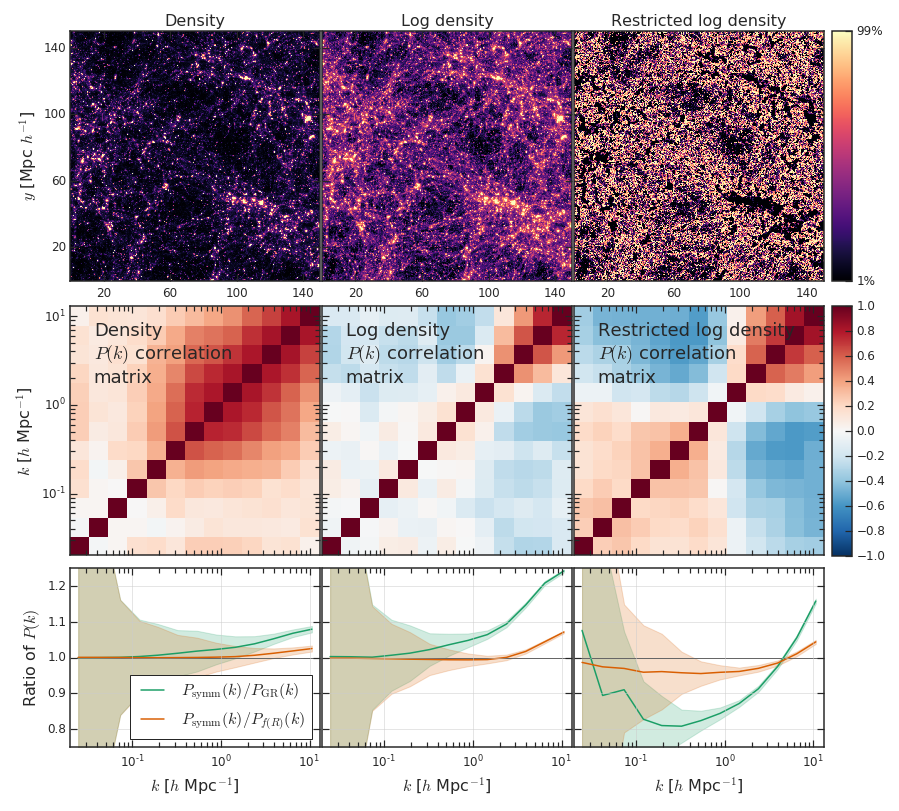

In [20]:
i=0
fig = plt.figure(figsize=(0.9*15, 0.9*14.5))
gs = gridspec.GridSpec(3, 3, height_ratios=[2,2,1.3])
for fx in ['dens', 'log', 'x1']:
    gs.update(wspace=0.01)
    
    plot_everything(fig, gs, xx, xform[fx](dens['GR']), k, corr_GR[fx], xform_label[fx], \
                           pk_paired['symm_a'][fx], pk_paired['fofr6'][fx], pk_paired['GR'][fx], cov_GR[fx], \
                    i, cmap1='magma', cmap2='RdBu_r', ncols=3)
    i=i+1
    
plt.savefig(figurepath+'dens_cov_ratios.png', dpi=250)

### Compute the signal to noise in the GR power spectra of the 3 transforms

In [18]:

for fx in ['dens', 'log', 'x1']:
    print fx
    print 'S/N=',N.sqrt(N.dot(N.dot(pk_paired['GR'][fx], N.linalg.inv(cov_GR[fx])), pk_paired['GR'][fx]))

 dens
S/N= 85.7967875054
log
S/N= 434.593445003
x1
S/N= 485.338733352
